# UK Actuarial Climate Index (ACI) Analysis

This notebook presents a comprehensive analysis of UK climate extremes using the Actuarial Climate Index (ACI) framework. It integrates multiple climate variables—such as temperature extremes, precipitation, wind speed, humidity, and solar potential—from national and global datasets. The workflow includes data extraction, preprocessing, correlation analysis, principal component analysis (PCA), and the construction of both standard and weighted ACI indices. The goal is to quantify climate risk trends across the UK, providing insights for risk assessment and climate adaptation strategies.

## Installation of the Required Packages



In [56]:
#pip install -r requirements.txt

In [ ]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Pulling the Datasets

The climate analysis in this notebook relies on multiple datasets, primarily in NetCDF format, which contain annual climate variables for the UK and global indices. These datasets are loaded using the `netCDF4` library and processed into pandas DataFrames for further analysis.

- **UK-wide variables** (e.g., wind speed, pressure, humidity, frost, snow, solar potential, sunshine) are sourced from the HadUK-Grid and related datasets.
- **Extreme indices** (e.g., TX90p, TN10p, Rx5day, CDD) are sourced from global gridded NetCDF files, with spatial averaging applied over the UK region.

The code extracts the relevant variables, aligns them by year, and merges them into a unified DataFrame (`final_uk_df`) for subsequent correlation, PCA, and index construction steps. This ensures all analyses are based on a consistent set of years and variables.

In [ ]:
data_files_1 = {
    "sfcWind": "wns/sfcWind_hadukgrid_uk_country_ann_196901-202312.nc",
    "psl": "wns/psl_hadukgrid_uk_country_ann_196101-202312.nc",
    "snowLying": "wns/snowLying_hadukgrid_uk_country_ann_197101-202312.nc",
    "hurs": "wns/hurs_hadukgrid_uk_country_ann_196101-202312.nc",
    "groundfrost": "wns/groundfrost_hadukgrid_uk_country_ann_196101-202312.nc",
    "pv": "wns/pv_hadukgrid_uk_country_ann_196101-202312.nc",
    "sun": "wns/sun_hadukgrid_uk_country_ann_191001-202312.nc"
}
data_files_2 = {
    "TX90p": "nc_data/GHCND_TX90p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "TX10p": "nc_data/GHCND_TX10p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "TN90p": "nc_data/GHCND_TN90p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "TN10p": "nc_data/GHCND_TN10p_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "Rx5day": "nc_data/GHCND_Rx5day_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc",
    "CDD": "nc_data/GHCND_CDD_1951-2025_RegularGrid_global_2.5x2.5deg_m4.nc"
}

## Climate Variables Used in the UK ACI Analysis
| Variable Name      | Description                                 | Units            | Notes                                                                                 |
|--------------------|---------------------------------------------|------------------|---------------------------------------------------------------------------------------|
| sfcWind            | Surface wind speed                          | m/s              | Annual mean wind speed over the UK                                                    |
| psl                | Sea-level pressure                          | hPa              | Annual mean sea-level pressure                                                        |
| snowLying          | Days with lying snow                        | days             | Annual total number of days with snow on the ground                                   |
| hurs               | Relative humidity                           | %                | Annual mean relative humidity                                                         |
| groundfrost        | Days with ground frost                      | days             | Annual total number of ground frost days                                              |
| pv                 | Photovoltaic potential                      | kWh/m²           | Annual mean solar energy potential                                                    |
| sun                | Sunshine duration                           | hours            | Annual total sunshine hours                                                           |
| Rx5day             | Maximum 5-day precipitation                 | mm               | Annual maximum precipitation over any consecutive 5 days                              |
| CDD                | Consecutive dry days                        | days             | Annual maximum number of consecutive days with little or no precipitation             |
| Temperature_Avg    | Average temperature index (TX/TN extremes)  | °C (index)       | Mean of temperature extremes indices (TX90p, TX10p, TN90p, TN10p)                     |

### **Explanation:**

The table above summarizes the climate variables used in the analysis. These variables are derived from UK-wide annual climate datasets, including wind speed, pressure, humidity, frost, snow, solar potential, sunshine, precipitation, dry spells, and temperature extremes. Each variable is selected for its relevance to climate risk and impact assessment. The data are standardized and, where appropriate, inverted so that higher values consistently indicate more extreme or adverse climate conditions. This harmonization enables the construction of composite indices such as the Actuarial Climate Index (ACI) for trend analysis and risk quantification.

In [ ]:
# Initialize dictionary for processed data
climate_data = {}

# Find the common years available across all datasets
common_years = None  # This will store the overlapping range

for var, file_path in data_files_1.items():
    # Open the NetCDF file
    dataset = nc.Dataset(file_path)

    # Extract time values & convert to years
    time_raw = dataset.variables["time"][:]  # Time in hours since 1800-01-01
    base_time = datetime.datetime(1800, 1, 1)
    years = np.array([base_time + datetime.timedelta(hours=int(t)) for t in time_raw])
    years = np.array([t.year for t in years])  # Extract only years

    # Keep track of common year range
    if common_years is None:
        common_years = set(years)
    else:
        common_years = common_years.intersection(set(years))

    # Extract climate data (assuming the variable name is the same as the file key)
    variable_name = var  # Adjust if needed
    if variable_name not in dataset.variables:
        print(f"Warning: {variable_name} not found in {file_path}. Available: {dataset.variables.keys()}")
        continue

    # Store data
    climate_data[var] = pd.Series(np.nanmean(dataset.variables[variable_name][:], axis=1), index=years)

# Convert dictionary to DataFrame
uk_climate_df = pd.DataFrame(climate_data)

# Filter to only keep common years
uk_climate_df = uk_climate_df.loc[sorted(common_years)]

# Set index name
uk_climate_df.index.name = "Year"

# Show first rows
#print(uk_climate_df.head())

### NCD4 FILES ANALYSIS

In [ ]:
# Define geographic boundaries for the UK (approximate)
lat_min_uk, lat_max_uk = 49.0, 61.0    # latitude range for UK
lon_min_uk, lon_max_uk = -8.5, 2.0     # longitude range for UK (note: negative for West)

# Open each NetCDF file and store the dataset
datasets = {name: nc.Dataset(path) for name, path in data_files_2.items()}

# For convenience, extract the coordinate arrays (assume all share same grid)
lats = datasets["TX90p"].variables["lat"][:]
lons = datasets["TX90p"].variables["lon"][:]

# Find index range for latitudes within UK bounds
lat_indices = np.where((lats >= lat_min_uk) & (lats <= lat_max_uk))[0]

# Find index range for longitudes within UK bounds (accounting for wrap-around)
if lon_min_uk < 0:
    lon_min_mod = lon_min_uk + 360.0  # e.g., -8.5 -> 351.5
else:
    lon_min_mod = lon_min_uk
if lon_min_mod <= lon_max_uk:
    # If the range does not cross the 0 meridian
    lon_indices = np.where((lons >= lon_min_mod) & (lons <= lon_max_uk))[0]
else:
    # Range crosses 0°E (i.e., includes 360->... and 0->...)
    lon_indices = np.where((lons >= lon_min_mod) | (lons <= lon_max_uk))[0]
    
# Determine the years from the time variable (assuming format YYYY0101 as integer)
time_vals = datasets["TX90p"].variables["time"][:]  # e.g., [19510101, 19520101, ...]
years = (time_vals // 10000).astype(int)  # extract the year part

# Initialize a dictionary to store UK annual series for each index
uk_annual_series = {}

for name, ds in datasets.items():
    # Annual values for all years and all grid cells
    annual_data = ds.variables["Ann"][:]  # shape: [time, lat, lon]
    # Subset to UK region grid cells
    uk_region_data = annual_data[:, lat_indices.min():lat_indices.max()+1, lon_indices.min():lat_indices.max()+1]
    # Compute spatial average over the region (mean over lat and lon dimensions)
    uk_mean = np.nanmean(uk_region_data, axis=(1, 2))
    uk_annual_series[name] = uk_mean

# Convert to pandas DataFrame for convenience
uk_df = pd.DataFrame(uk_annual_series, index=years)
uk_df.index.name = "Year"

# Calculate the average temperature index
uk_df['Temperature_Avg'] = uk_df[['TN90p', 'TN10p', 'TX90p', 'TX10p']].mean(axis=1)

# Remove the TX and TN columns
uk_df = uk_df.drop(columns=['TX90p', 'TX10p', 'TN90p', 'TN10p'])

# Ensure both DataFrames have the same index (common years)
common_years = uk_climate_df.index.intersection(uk_df.index)

# Filter both DataFrames to keep only common years
uk_climate_df = uk_climate_df.loc[common_years]
uk_df = uk_df.loc[common_years]

# Merge both DataFrames on 'Year' index
final_uk_df = pd.concat([uk_climate_df, uk_df], axis=1)

# Drop any rows with missing values (if any)
final_uk_df = final_uk_df.dropna()

# Quick check of the DataFrame
print(final_uk_df.head(2))
print("...\n", final_uk_df.tail(2))

       sfcWind          psl  snowLying       hurs  groundfrost        pv  \
Year                                                                       
1971  4.962362  1015.565624   9.135744  83.523936   101.694229  9.864356   
1972  5.347892  1013.548421   8.843877  83.309843   106.148431  9.411361   

              sun     Rx5day        CDD  Temperature_Avg  
Year                                                      
1971  1370.797079  59.890179  31.424616        10.699383  
1972  1300.150819  57.858517  33.814617        10.626331  
...
        sfcWind          psl  snowLying       hurs  groundfrost         pv  \
Year                                                                        
2022  5.071772  1014.527087   7.332067  81.256641    80.125319  10.305399   
2023  5.013548  1012.154694   6.980320  83.277861    70.631539  10.649161   

              sun     Rx5day        CDD  Temperature_Avg  
Year                                                      
2022  1548.998889  67.81878

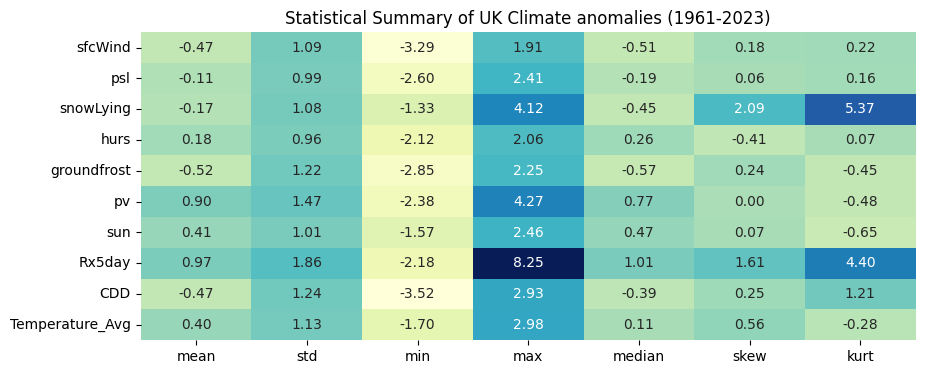

In [61]:
# Get statistical summaries for all variables in final_uk_df

baseline_means_unweighted = final_uk_df[baseline_mask].mean()
baseline_stds_unweighted = final_uk_df[baseline_mask].std(ddof=0)

# Standardize all variables (Z-score transformation)
aci_unweighted = (final_uk_df - baseline_means_unweighted) / baseline_stds_unweighted

stats_non_pc1 = aci_unweighted.agg(['mean', 'std', 'min', 'max', 'median', 'skew', 'kurt'])

stats_table_n_pc1 = stats_non_pc1.T

plt.figure(figsize=(10, 4))
sns.heatmap(stats_table_n_pc1, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Statistical Summary of UK Climate anomalies (1961-2023)")
plt.yticks(rotation=0)
plt.show()

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns

# Prepare column names for the principal components
n_components = pcn_time_series.shape[1]
pc_columns = [f"PC{i+1}" for i in range(n_components)]

# Create a DataFrame for easier analysis
pcn_df = pd.DataFrame(pcn_time_series, index=years, columns=pc_columns)

# Compute statistics for each principal component
stats = pcn_df.agg(['mean', 'std', 'min', 'max', 'median', 'skew', 'kurt'])

# Transpose for a table format (PCs as rows)
stats_table = stats.T

# Display the table
print(stats_table)

# Optionally, display as a nicely formatted table in Jupyter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.heatmap(stats_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Statistical Summary of Principal Components")
plt.yticks(rotation=0)
plt.show()

ValueError: Shape of passed values is (53, 5), indices imply (75, 5)

## Correlation Analysis


The aim of this section is to explore the relationships between key climate variables used in the UK Actuarial Climate Index (ACI) analysis. By examining the correlation matrix, we can identify which variables are strongly related, detect potential redundancies, and inform subsequent steps such as factor inversion and index construction.

Seaborn is used to visualize the correlation matrix as a heatmap, providing an intuitive overview of the linear associations between variables.

In [66]:
# Compute correlation matrix for pv, sun, temperature, and humidity (hurs)
correlation_vars = ["CDD", "psl", "Temperature_Avg", "Rx5day","sfcWind", "hurs", "snowLying", "groundfrost", "pv", "sun"]
correlation_df_1 = final_uk_df[correlation_vars].corr()

### Inversion of Factors

From the analysis above, we observe that CDD (Consecutive Dry Days) is positively correlated with snowLying, which is counterintuitive since more dry days should typically mean less snow. This indicates that some factors may need to be inverted to accurately represent their true relationship and impact in the correlation analysis and index construction.

In [67]:
# Copy the relevant DataFrame to avoid modifying the original
corr_2_df = final_uk_df.copy()

# Automatically invert variables that are positively correlated with snowLying or groundfrost (where negative correlation is expected)
invert_vars = []
reference_vars = ["snowLying", "groundfrost"]

for var in correlation_vars:
    for ref in reference_vars:
        if var != ref and ref in corr_2_df.columns:
            corr = corr_2_df[[var, ref]].corr().iloc[0, 1]
            # If correlation is positive (unexpected), mark for inversion
            if corr > 0:
                invert_vars.append(var)

# Remove duplicates and invert
invert_vars = list(set(invert_vars))
for var in invert_vars:
    if var in corr_2_df.columns:
        corr_2_df[var] = -corr_2_df[var]

# Compute correlation matrix for selected variables
correlation_vars = ["CDD", "psl", "Temperature_Avg", "Rx5day", "sfcWind", "hurs", "snowLying", "groundfrost", "pv", "sun"]
correlation_df_2 = corr_2_df[correlation_vars].corr()

In [ ]:
plt.figure(figsize=(16, 6))

# Plot correlation_df_1
plt.subplot(1, 2, 1)
sns.heatmap(correlation_df_1, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix (Original)")

# Plot correlation_df_2
plt.subplot(1, 2, 2)
sns.heatmap(correlation_df_2, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix (With Inversion)")

plt.tight_layout()
plt.show()

## ACI Creation

In [ ]:
import numpy as np
import pandas as pd

# Define the baseline reference period
ref_start, ref_end = 1971, 2000  # Adjust based on available data
baseline_mask = (final_uk_df.index >= ref_start) & (final_uk_df.index <= ref_end)

# Compute mean & standard deviation over baseline
baseline_means = final_uk_df[baseline_mask].mean()
baseline_stds = final_uk_df[baseline_mask].std(ddof=0)

# Standardize variables (Z-score transformation)
aci_data = (final_uk_df - baseline_means) / baseline_stds

# Invert variables where lower values indicate more extreme conditions
aci_data["psl"] = -aci_data["psl"]   # Lower pressure = More storms, so invert
aci_data["hurs"] = -aci_data["hurs"]  # Lower humidity = More drought risk, so invert

# Compute overall ACI (average of standardized values)
aci_data["ACI"] = aci_data.mean(axis=1)

# Show results
print(aci_data.head())


       sfcWind       psl  snowLying      hurs  groundfrost        pv  \
Year                                                                   
1971 -1.536310 -1.267209  -0.637013 -1.164994    -0.286444  0.925513   
1972  0.069164  0.187730  -0.677118 -0.955705     0.080898 -1.007319   
1973 -0.509213 -2.406955  -0.080097 -0.361523     0.772099  0.331643   
1974  1.863841  1.272572  -1.027454 -0.105387    -0.159916 -0.976488   
1975 -0.163486 -2.001372  -0.945370  0.134377     0.600654  0.747009   

           sun    Rx5day       CDD  Temperature_Avg       ACI  
Year                                                           
1971  0.141828 -0.013884 -0.607163         0.139915 -0.430576  
1972 -0.616365 -0.926636  0.211633         0.059231 -0.357449  
1973  0.153526 -0.439999 -0.717515        -0.989177 -0.424721  
1974  0.118250 -1.775581  0.800535        -0.703487 -0.069312  
1975  1.867537 -2.184171 -0.578712        -0.270760 -0.279430  


UNMODIFIED

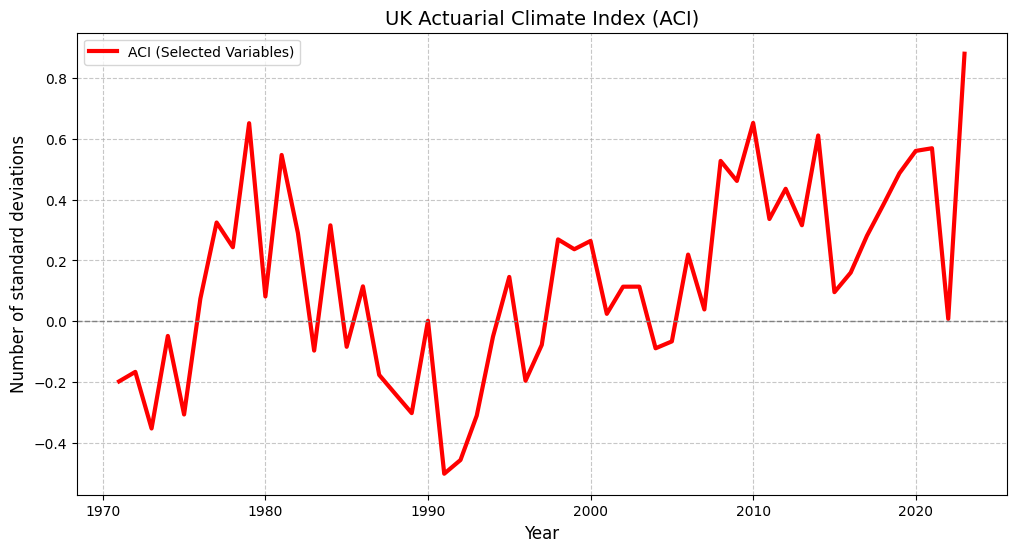

In [68]:
import matplotlib.pyplot as plt
# Compute mean & standard deviation over baseline for selected variables
baseline_means_selected = final_uk_df[baseline_mask].mean()
baseline_stds_selected = final_uk_df[baseline_mask].std(ddof=0)

# Standardize the selected variables (Z-score transformation)
aci_selected = (final_uk_df - baseline_means_selected) / baseline_stds_selected

# Invert psl (Sea-Level Pressure) since lower values indicate higher climate risks
aci_selected["psl"] = -aci_selected["psl"]

# Compute the new ACI as the mean of selected standardized variables
aci_selected["ACI_Selected"] = aci_selected.mean(axis=1)

# Plot the new ACI trend over time
plt.figure(figsize=(12, 6))
plt.plot(aci_selected.index, aci_selected["ACI_Selected"], linewidth=3, color="red", label="ACI (Selected Variables)")

plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Reference line at zero
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of standard deviations", fontsize=12)
plt.title("UK Actuarial Climate Index (ACI)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()



MODIFIED

BOTH

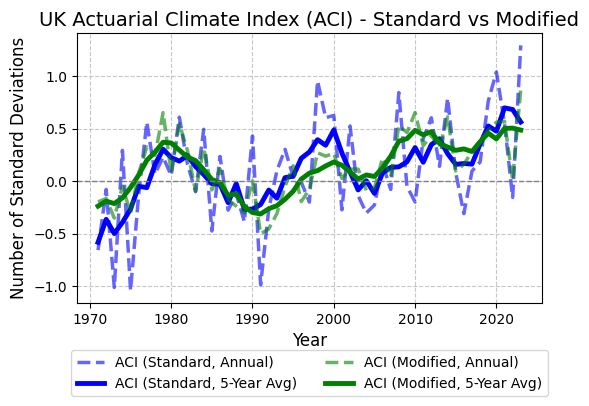

In [ ]:
# Compute the full ACI using all available climate variables
all_aci_variables = final_uk_df.columns  # Use all variables in the dataset

# Compute mean & standard deviation over baseline for all variables
baseline_means_all = final_uk_df[baseline_mask][all_aci_variables].mean()
baseline_stds_all = final_uk_df[baseline_mask][all_aci_variables].std(ddof=0)

# Standardize all variables (Z-score transformation)
aci_full = (final_uk_df - baseline_means_all) / baseline_stds_all

# Invert psl (Sea-Level Pressure) since lower values indicate higher climate risks
if "psl" in aci_full.columns:
    aci_full["psl"] = -aci_full["psl"]

# Compute the full ACI as the mean of all standardized variables
aci_full["ACI_Full"] = aci_full.mean(axis=1)

# Apply a 5-year moving average for smoothing
aci_selected["ACI_Selected_5yr"] = aci_selected["ACI_Selected"].rolling(window=5, center=True, min_periods=3).mean()
aci_full["ACI_Full_5yr"] = aci_full["ACI_Full"].rolling(window=5, center=True, min_periods=3).mean()

# Plot the ACI trends with 5-year rolling averages
plt.figure(figsize=(6, 3.5))
plt.plot(aci_selected.index, aci_selected["ACI_Selected"], linewidth=2.5, linestyle="--", color="blue", alpha=0.6, label="ACI (Standard, Annual)")
plt.plot(aci_selected.index, aci_selected["ACI_Selected_5yr"], linewidth=3.5, color="blue", label="ACI (Standard, 5-Year Avg)")
plt.plot(aci_full.index, aci_full["ACI_Full"], linewidth=2.5, linestyle="--", color="green", alpha=0.6, label="ACI (Modified, Annual)")
plt.plot(aci_full.index, aci_full["ACI_Full_5yr"], linewidth=3.5, color="green", label="ACI (Modified, 5-Year Avg)")

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Standard Deviations", fontsize=12)
plt.title("UK Actuarial Climate Index (ACI) - Standard vs Modified", fontsize=14)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)  # Move legend to bottom
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


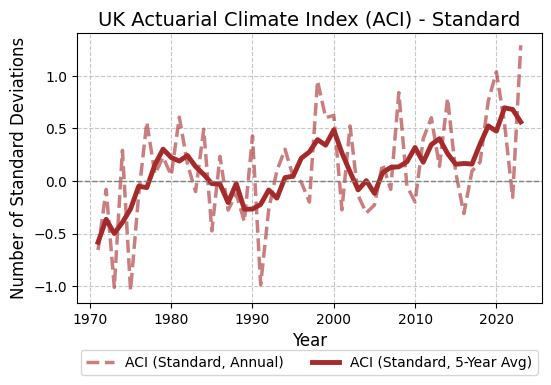

In [ ]:
plt.figure(figsize=(6, 3.5))
aci_selected["ACI_Selected_5yr"] = aci_selected["ACI_Selected"].rolling(window=5, center=True, min_periods=3).mean()
plt.plot(aci_selected.index, aci_selected["ACI_Selected"], linewidth=2.5, linestyle="--", color="brown", alpha=0.6, label="ACI (Standard, Annual)")
plt.plot(aci_selected.index, aci_selected["ACI_Selected_5yr"], linewidth=3.5, color="brown", label="ACI (Standard, 5-Year Avg)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Standard Deviations", fontsize=12)
plt.title("UK Actuarial Climate Index (ACI) - Standard", fontsize=14)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)  # Move legend to bottom
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


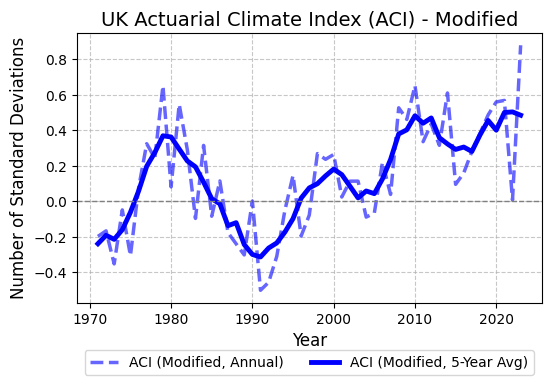

In [ ]:
aci_full["ACI_Full_5yr"] = aci_full["ACI_Full"].rolling(window=5, center=True, min_periods=3).mean()

plt.figure(figsize=(6, 3.5))
plt.plot(aci_full.index, aci_full["ACI_Full"], linewidth=2.5, linestyle="--", color="blue", alpha=0.6, label="ACI (Modified, Annual)")
plt.plot(aci_full.index, aci_full["ACI_Full_5yr"], linewidth=3.5, color="blue", label="ACI (Modified, 5-Year Avg)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Standard Deviations", fontsize=12)
plt.title("UK Actuarial Climate Index (ACI) - Modified", fontsize=14)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)  # Move legend to bottom
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

## Final Weighted Actuarial Climate Index (W-ACI) Data 

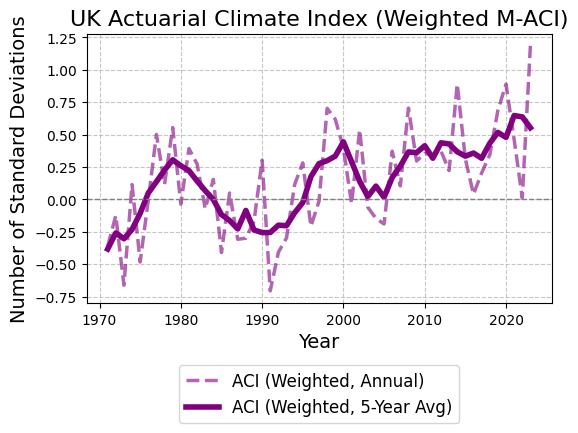

In [ ]:
# Define weights for all climate variables (ensure sum = 1.0)
aci_weights = {
    "Temperature_Avg": 0.2,  # Strong climate impact
    "CDD": 0.1,  # Drought indicator
    "sfcWind": 0.15,  # Wind-related storms
    "psl": 0.15,  # Sea-level pressure (inverted)
    "Rx5day": 0.1,  # Extreme rainfall
    "snowLying": 0.05,  # Snow cover
    "hurs": 0.05,  # Humidity
    "groundfrost": 0.05,  # Frost events
    "pv": 0.075,  # Solar energy changes
    "sun": 0.075  # Sunlight duration
}

# Ensure only available variables are used
weighted_aci_variables = {var: weight for var, weight in aci_weights.items() if var in final_uk_df.columns}

# Define baseline reference period
ref_start, ref_end = 1971, 2000  # Adjust as needed
baseline_mask = (final_uk_df.index >= ref_start) & (final_uk_df.index <= ref_end)

# Compute mean & standard deviation over baseline for weighted ACI
baseline_means_weighted = final_uk_df[baseline_mask][weighted_aci_variables.keys()].mean()
baseline_stds_weighted = final_uk_df[baseline_mask][weighted_aci_variables.keys()].std(ddof=0)

# Standardize selected variables (Z-score transformation)
aci_weighted = (final_uk_df[weighted_aci_variables.keys()] - baseline_means_weighted) / baseline_stds_weighted

# Invert psl (Sea-Level Pressure) since lower values indicate higher climate risks
if "psl" in aci_weighted.columns:
    aci_weighted["psl"] = -aci_weighted["psl"]

# Compute the weighted ACI using the defined weights
aci_weighted["ACI_Weighted"] = sum(aci_weighted[var] * weight for var, weight in weighted_aci_variables.items())


## Un-Weighted Actuarial Climate Index (U-ACI) Data 

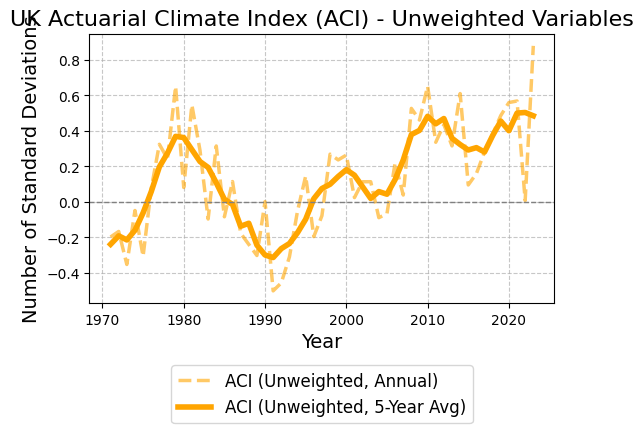

In [ ]:
# Compute mean & standard deviation over baseline for all available climate variables
baseline_means_unweighted = final_uk_df[baseline_mask].mean()
baseline_stds_unweighted = final_uk_df[baseline_mask].std(ddof=0)

# Standardize all variables (Z-score transformation)
aci_unweighted = (final_uk_df - baseline_means_unweighted) / baseline_stds_unweighted

# Invert psl (Sea-Level Pressure) since lower values indicate higher climate risks
if "psl" in aci_unweighted.columns:
    aci_unweighted["psl"] = -aci_unweighted["psl"]

# Compute the unweighted ACI as the mean of all standardized variables
aci_unweighted["ACI_Unweighted"] = aci_unweighted.mean(axis=1)

# Apply a 5-year moving average for smoothing
aci_unweighted["ACI_Unweighted_5yr"] = aci_unweighted["ACI_Unweighted"].rolling(window=5, center=True, min_periods=3).mean()


## Comparison of the Weighted Actuarial Climate Data anomalies as the ACI

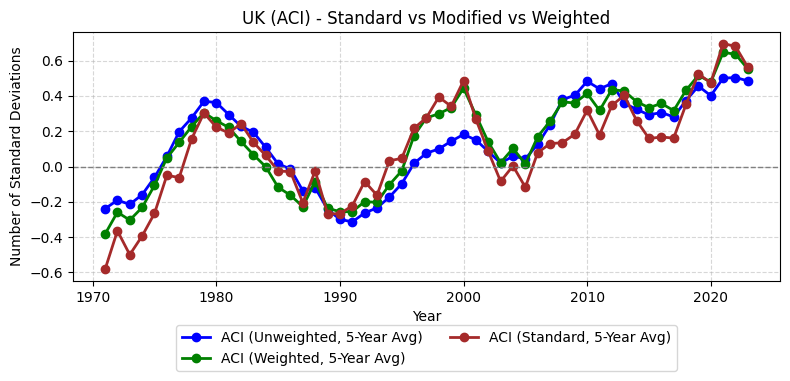

In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(aci_unweighted.index, aci_unweighted["ACI_Unweighted_5yr"], marker='o', linewidth=2, color="blue", label="ACI (Unweighted, 5-Year Avg)")
plt.plot(aci_weighted.index, aci_weighted["ACI_Weighted_5yr"], marker='o', linewidth=2, color="green", label="ACI (Weighted, 5-Year Avg)")
plt.plot(aci_selected.index, aci_selected["ACI_Selected_5yr"], marker='o', linewidth=2, color="brown", label="ACI (Standard, 5-Year Avg)")

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Number of Standard Deviations")
plt.title("UK (ACI) - Standard vs Modified vs Weighted")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)
plt.tight_layout()
plt.savefig("report/aci_comparison_report.png", dpi=300)
plt.show()


## Principal Component Analysis (PCA) on the ACI data

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Standardize the data (z-score) before PCA

# Drop any rows with missing values (if any)
data_for_pca = final_uk_df.dropna()

# Standardize features
scaler = StandardScaler()
data_std = scaler.fit_transform(data_for_pca)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(data_std)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_var) + 1), explained_var * 100, alpha=0.7)
plt.step(range(1, len(explained_var) + 1), explained_var.cumsum() * 100, where='mid', color='red', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('PCA - Explained Variance by Component')
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("report/pca_explained_variance_report.png", dpi=300)
plt.close()
plt.show()

# Optionally, show the loadings for the first principal component
pca_loadings = pd.Series(pca.components_[0], index=data_for_pca.columns)
print("First principal component loadings:")
print(pca_loadings)

First principal component loadings:
sfcWind           -0.219642
psl               -0.105708
snowLying         -0.287506
hurs               0.021088
groundfrost       -0.436463
pv                 0.469523
sun                0.267895
Rx5day             0.373598
CDD               -0.346500
Temperature_Avg    0.339296
dtype: float64


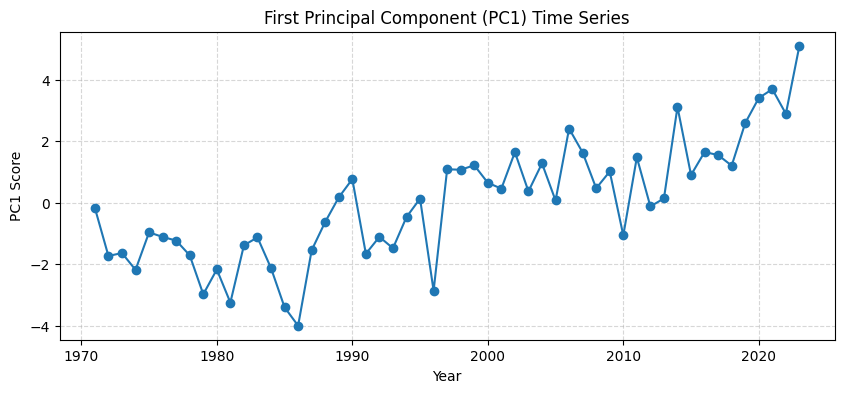

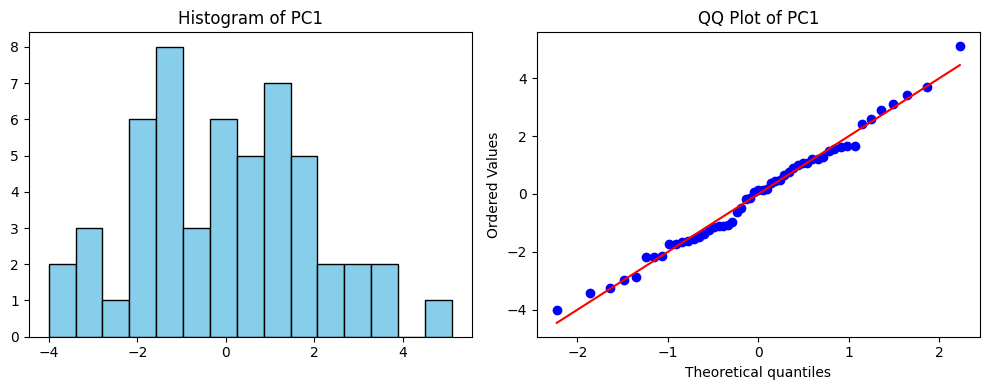

<Figure size 640x480 with 0 Axes>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from scipy.stats import probplot

import matplotlib.pyplot as plt

# Use the first principal component time series from PCA as the ACI proxy
# If not already available, compute it:
# pc1_time_series = pca_result[:, 0]

# Align years with PC1 (use final_uk_df.index if needed)
pc1_years = final_uk_df.index
pc1_series = pca_result[:, 0]

# Plot the PC1 time series
plt.figure(figsize=(10, 4))
plt.plot(pc1_years, pc1_series, marker='o')
plt.title('First Principal Component (PC1) Time Series')
plt.xlabel('Year')
plt.ylabel('PC1 Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("report/pc1_ts.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Histogram and QQ plot for normality check

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(pc1_series, bins=15, color='skyblue', edgecolor='k')
plt.title('Histogram of PC1')

plt.subplot(1, 2, 2)
probplot(pc1_series, dist="norm", plot=plt)
plt.title('QQ Plot of PC1')
plt.tight_layout()
plt.show()
plt.savefig("report/pc1_time_series_analysis.png", dpi=300, bbox_inches='tight')

/var/folders/tf/zx5mk77s22gb5d54kwpvsrh40000gn/T/ipykernel_12223/3894766361.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_dates = pd.date_range(start=annual_dates.min(), end=annual_dates.max() + pd.offsets.MonthEnd(5), freq='M')


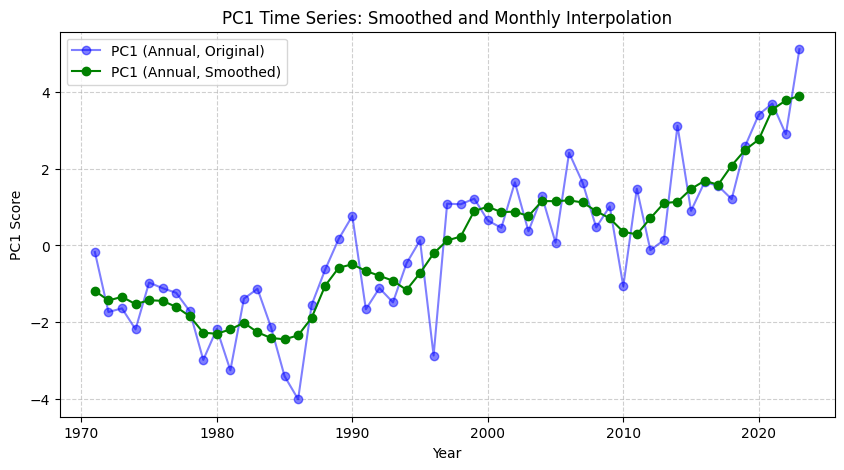

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare annual PC1 data as a pandas Series
pc1_series = pcn_time_series[:, 0]
years = final_uk_df.index[:len(pc1_series)]

# Smooth with a 5-year moving average
pc1_smooth = pd.Series(pc1_series, index=years).rolling(window=5, center=True, min_periods=3).mean()

# Create a DataFrame with years as datetime index (set to mid-year for clarity)
annual_dates = pd.to_datetime(years.astype(str)) + pd.offsets.MonthBegin(7)
pc1_df = pd.DataFrame({'PC1': pc1_smooth.values}, index=annual_dates)

# Create a monthly date range covering the full span
monthly_dates = pd.date_range(start=annual_dates.min(), end=annual_dates.max() + pd.offsets.MonthEnd(5), freq='M')

# Interpolate to monthly frequency (linear interpolation)
pc1_monthly = pc1_df.reindex(monthly_dates).interpolate(method='time')

# Prepare for plotting
months = pc1_monthly.index.year + (pc1_monthly.index.month - 1) / 12
y_months = pc1_monthly['PC1'].values
# Save the interpolated monthly PC1 series for later use
pc1_interpolated_monthly = pc1_monthly['PC1']
# Plot both annual and monthly (smoothed) PC1
plt.figure(figsize=(10, 5))
plt.plot(years, pc1_series, 'o-', label='PC1 (Annual, Original)', color='blue', alpha=0.5)
plt.plot(years, pc1_smooth, 'o-', label='PC1 (Annual, Smoothed)', color='green')
plt.xlabel('Year')
plt.ylabel('PC1 Score')
plt.title('PC1 Time Series: Smoothed and Monthly Interpolation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("report/pc1_interpolated_monthly.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_80 = np.searchsorted(cumulative_variance, 0.8) + 1  # +1 for index to count

print(f"Number of components to reach 80% variance: {n_components_80}")

# Select the first n_components_80 principal components
pcn_time_series = pca_result[:, :n_components_80]


Number of components to reach 80% variance: 5
